In [1]:
import gridstatusio as gs
import gridstatus as g
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import datetime
import requests
import Grid_Status_Functions as gf

****Objectives:****

1. When is peak demand in New England in December 2022? Time of day? Specific days?

2. How did LMPs change in Maine in December 2022? Did Winter Storm Elliot Affect this?

3. Does the fuel mix change at peak demand?

4. Would virtual power plants be helpful in Maine? When?


<h1><center>US ISOs</center></h1>

<div>
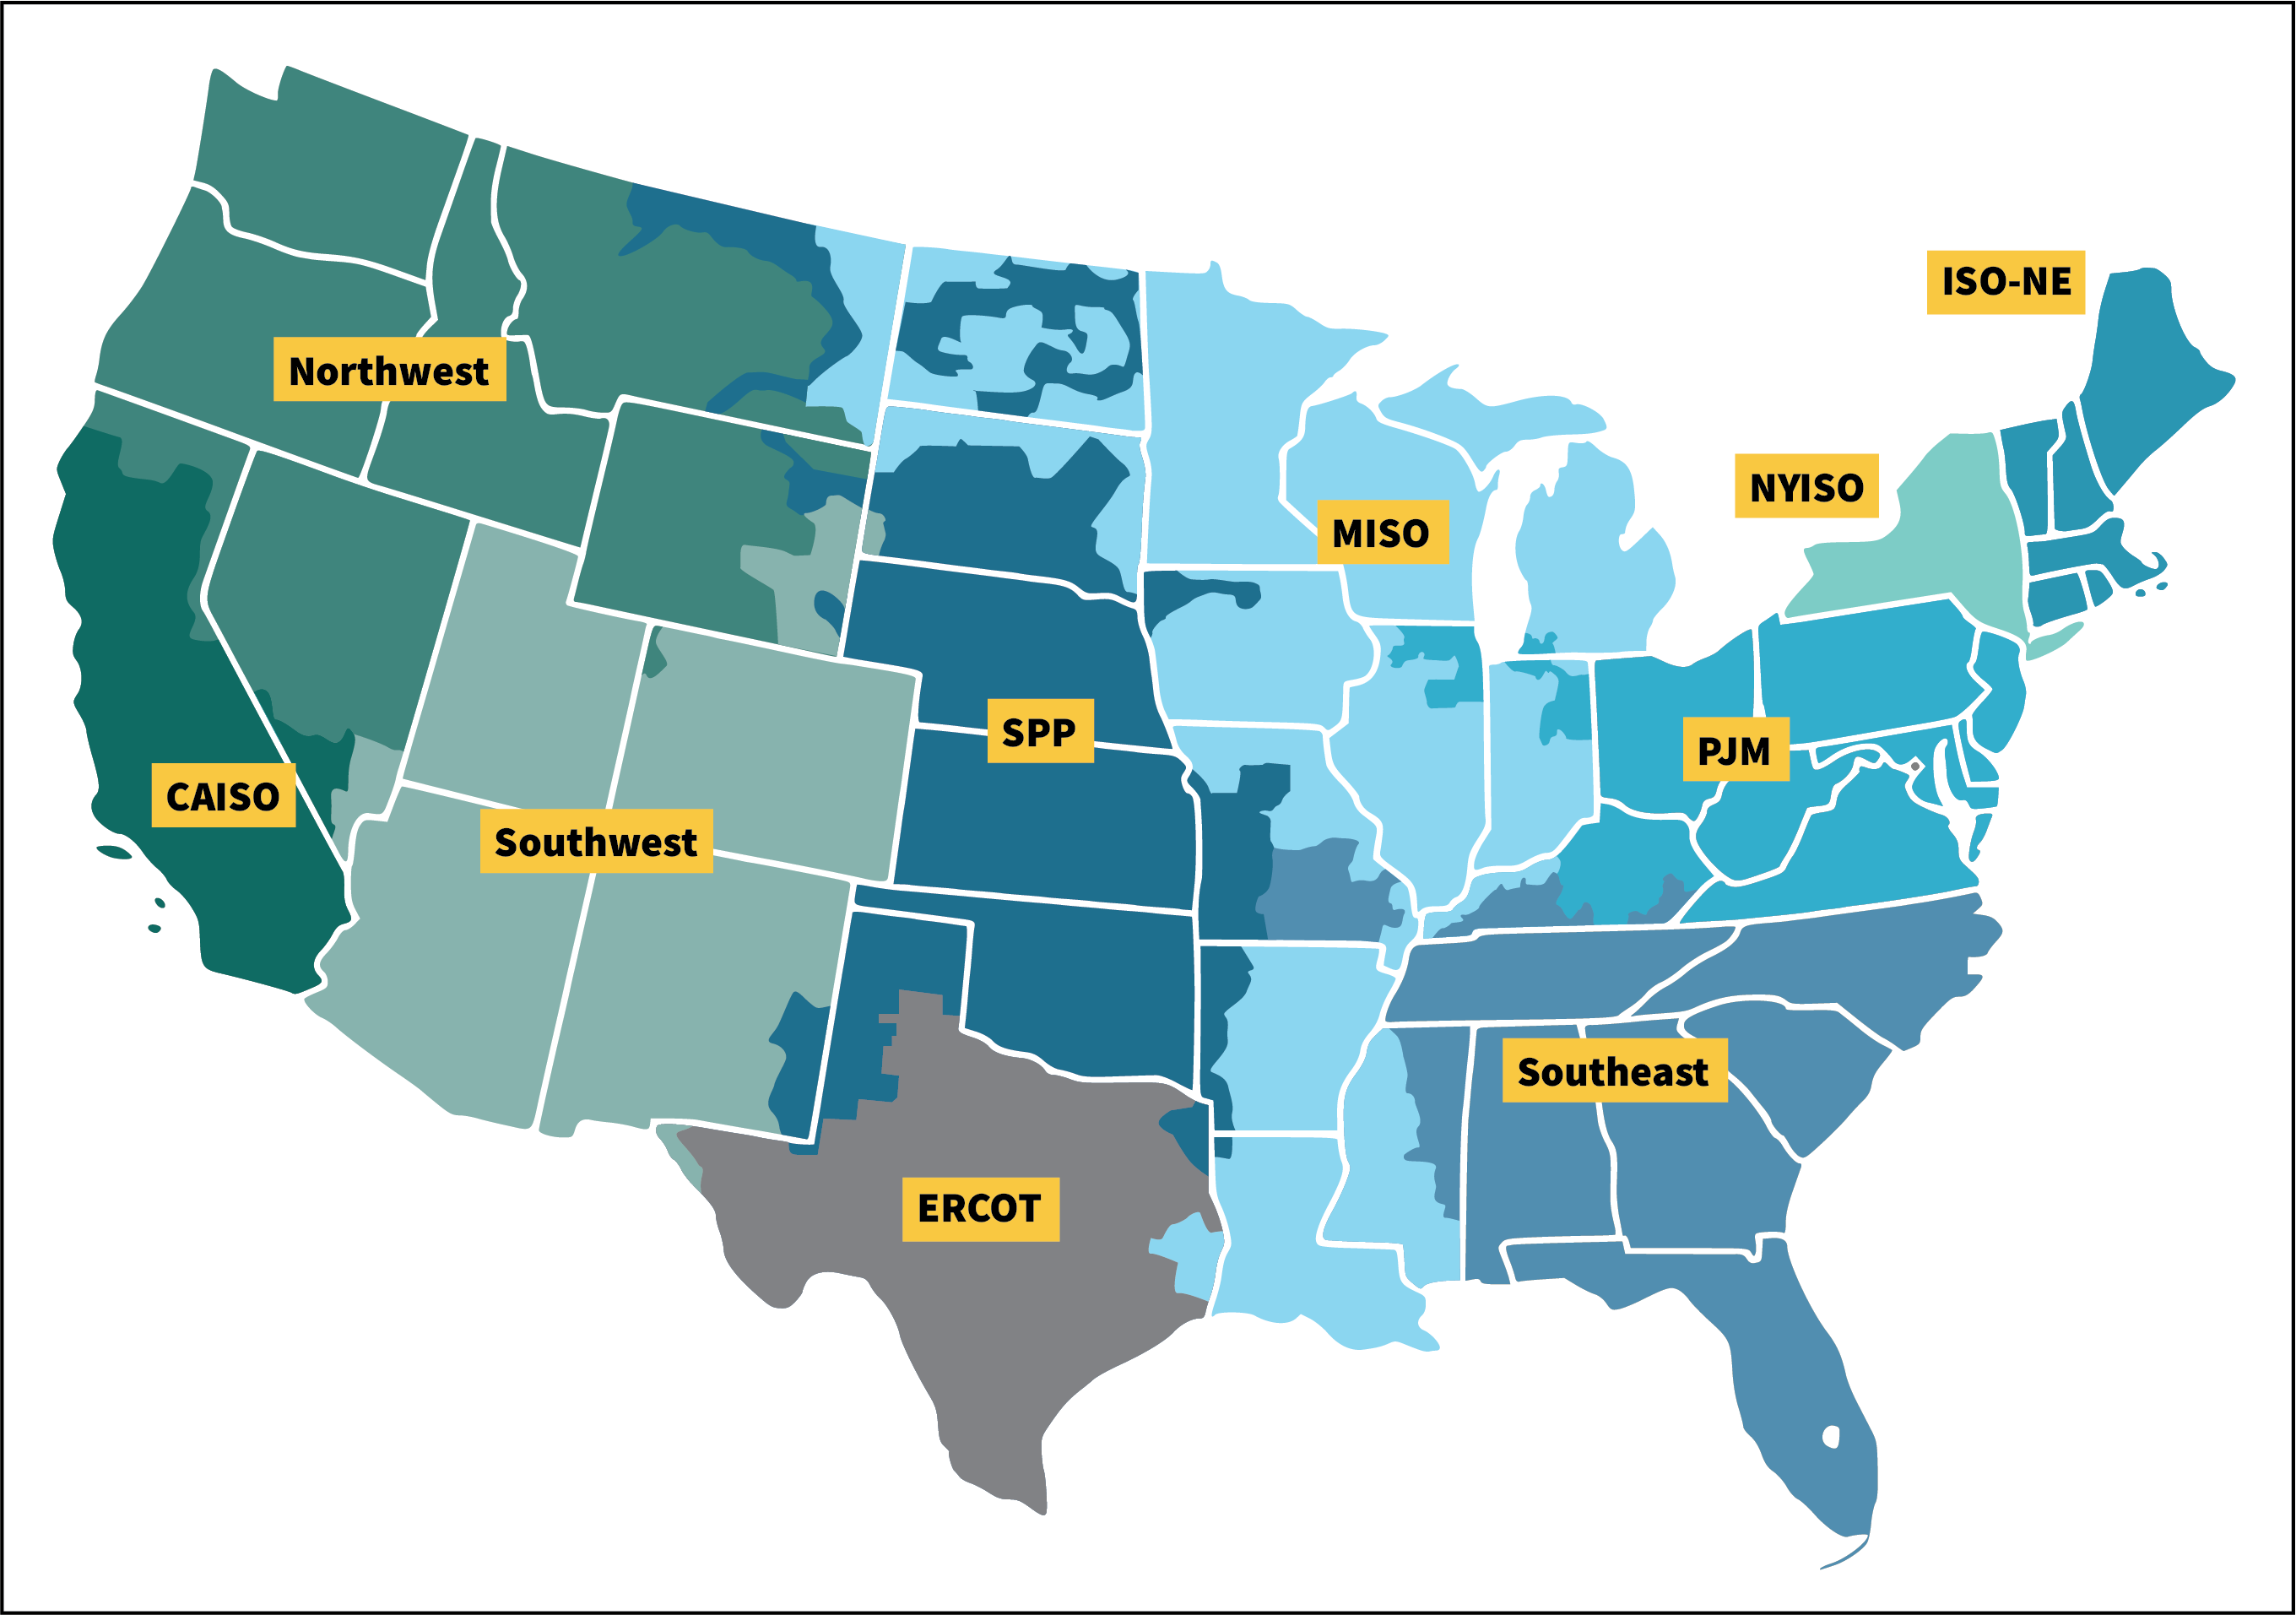
</div>
<div style="text-align: center"> source: https://www.ferc.gov/power-sales-and-markets/rtos-and-isos </div>

In [2]:
gs.api_key  = 'Hd8UWiGA7x6eVg99qOBBH6LUZkTh0ONM1OEeRZPZ'

In [3]:
df_datasets = pd.read_csv('https://data.gridstatus.io/datasets/historical_data_availability/latest.csv')

## Gridstatus datasets available for ISO-NE

In [161]:
df_datasets[df_datasets["iso"].str.contains('isone')]

,iso,dataset,earliest,latest,num_missing,earliest_no_missing,missing,hidden
17,isone,daily_load_last_30_days,2023-01-24,2023-03-11,0,2023-01-24,[],True
18,isone,fuel_mix,2015-12-01,2023-03-11,2,2020-11-02,"['2019-11-03', '2020-11-01']",False
19,isone,fuel_mix_categorized,2015-12-01,2023-03-11,2,2020-11-02,"['2019-11-03', '2020-11-01']",False
20,isone,fuel_mix_clean,2015-12-01,2023-03-11,2,2020-11-02,"['2019-11-03', '2020-11-01']",False
21,isone,interconnection_queue,2023-02-02,2023-03-11,0,2023-02-02,[],False
22,isone,lmp_day_ahead_hourly,2016-01-01,2023-03-11,0,2016-01-01,[],False
23,isone,lmp_real_time_5_min,2021-01-12,2023-03-11,0,2021-01-12,[],False
24,isone,load,2020-11-30,2023-03-11,0,2020-11-30,[],False
25,isone,load_and_forecast,2020-11-30,2023-03-11,0,2020-11-30,[],False
26,isone,load_clean,2020-11-30,2023-03-11,0,2020-11-30,[],False


## GridStatus ISOs

In [5]:
ercot = g.Ercot()
isone = g.ISONE()
caiso = g.CAISO()
pjm = g.PJM()
miso = g.MISO()
spp = g.SPP()
nyiso = g.NYISO()

# Winter Storm Elliot 12/21/2022 - 12/26/2022 

We'll gather load and LMP data from ISONE from the month of December 2022 to evaluate when peak demand is and if that changed during the storm. According to poweroutage.com, over 300k customers were affected in ME, and around 200k customers were affected in each NH, MA, and VT.

## Get data from gridstatus API and save it locally

In [9]:
start = "2022-12-01"
end = "2022-12-31"

In [13]:
#Load data

isone_load_api = gs.get_dataset(
    dataset="isone/load",
    start=start,
    end=end,
)

isone_load_api.reset_index(inplace=True)
isone_load_api.to_csv('isone_load_dec2022.csv')
isone_load_api.to_parquet('isone_load_dec2022.parquet')

100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.27it/s]


In [22]:
#LMP data

isone_lmp_api = gs.get_dataset(
    dataset="isone/lmp_real_time_5_min",
    start=start,
    end=end,
)

isone_lmp_api.reset_index(inplace=True)
isone_lmp_api.to_csv('isone_lmp_dec2022.csv')
isone_lmp_api.to_parquet('isone_lmp_dec2022.parquet')

100%|███████████████████████████████████████████| 31/31 [00:52<00:00,  1.70s/it]


In [118]:
isone_mix_api = gs.get_dataset(
    dataset="isone/fuel_mix",
    start=start,
    end=end,
)

isone_mix_api.reset_index(inplace=True)
#isone_mix_api.to_csv('isone_mix_dec2022.csv')
isone_mix_api.to_parquet('isone_mix_dec2022.parquet')

100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.26it/s]


## Load local data

In [40]:
load_df = pd.read_parquet('isone_load_dec2022.parquet')

In [43]:
gf.basics(load_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8795 entries, 0 to 8794
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype                                 
---  ------  --------------  -----                                 
 0   Time    8795 non-null   datetime64[ns, pytz.FixedOffset(-300)]
 1   Load    8795 non-null   float64                               
dtypes: datetime64[ns, pytz.FixedOffset(-300)](1), float64(1)
memory usage: 137.5 KB
None 

                Load
count   8795.000000
mean   13634.196653
std     1788.662059
min     9606.120000
25%    12223.595000
50%    13648.605000
75%    15064.632500
max    17855.190000 

 Time    0
Load    0
dtype: int64 




,Time,Load
0,2022-12-01 00:00:00-05:00,10932.657
1,2022-12-01 00:05:00-05:00,10984.449
2,2022-12-01 00:10:00-05:00,10862.893
3,2022-12-01 00:15:00-05:00,10861.489
4,2022-12-01 00:20:00-05:00,10792.388


In [72]:
lmp_df = pd.read_parquet('isone_lmp_dec2022.parquet')

In [45]:
gf.basics(lmp_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133920 entries, 0 to 133919
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype                                 
---  ------         --------------   -----                                 
 0   Time           133920 non-null  datetime64[ns, pytz.FixedOffset(-300)]
 1   Market         133920 non-null  object                                
 2   Location       133920 non-null  object                                
 3   Location Type  133920 non-null  object                                
 4   LMP            133920 non-null  float64                               
 5   Energy         133920 non-null  float64                               
 6   Congestion     133920 non-null  float64                               
 7   Loss           133920 non-null  float64                               
dtypes: datetime64[ns, pytz.FixedOffset(-300)](1), float64(4), object(3)
memory usage: 8.2+ MB
None 

                  LMP       

,Time,Market,Location,Location Type,LMP,Energy,Congestion,Loss
0,2022-12-01 00:00:00-05:00,REAL_TIME_5_MIN,.H.INTERNAL_HUB,HUB,53.00,51.92,0.73,0.35
1,2022-12-01 00:00:00-05:00,REAL_TIME_5_MIN,.Z.MAINE,LOAD ZONE,42.82,51.92,-6.57,-2.53
2,2022-12-01 00:00:00-05:00,REAL_TIME_5_MIN,.Z.NEWHAMPSHIRE,LOAD ZONE,52.31,51.92,0.73,-0.34
3,2022-12-01 00:00:00-05:00,REAL_TIME_5_MIN,.Z.VERMONT,LOAD ZONE,51.21,51.92,-0.19,-0.52
4,2022-12-01 00:00:00-05:00,REAL_TIME_5_MIN,.Z.CONNECTICUT,LOAD ZONE,52.65,51.92,0.73,0.00


In [142]:
#The daily limit has been exceeded in this df, we will fetch it again after 2 pm 3/28 to get full month's data
mix_df = pd.read_parquet('isone_mix_dec2022.parquet')

In [143]:
gf.basics(mix_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6665 entries, 0 to 6664
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype                                 
---  ------        --------------  -----                                 
 0   Time          6665 non-null   datetime64[ns, pytz.FixedOffset(-300)]
 1   Coal          6665 non-null   float64                               
 2   Hydro         6665 non-null   float64                               
 3   Landfill Gas  6665 non-null   float64                               
 4   Natural Gas   6665 non-null   float64                               
 5   Nuclear       6665 non-null   float64                               
 6   Oil           4586 non-null   float64                               
 7   Other         6665 non-null   float64                               
 8   Refuse        6665 non-null   float64                               
 9   Solar         6665 non-null   float64                               
 10  

,Time,Coal,Hydro,Landfill Gas,Natural Gas,Nuclear,Oil,Other,Refuse,Solar,Wind,Wood
0,2022-12-01 00:05:13-05:00,8.0,916.0,31.0,3869.0,3365.0,0.0,0.0,283.0,1.0,991.0,158.0
1,2022-12-01 00:11:11-05:00,6.0,916.0,31.0,4023.0,3366.0,0.0,0.0,283.0,1.0,1014.0,159.0
2,2022-12-01 00:22:31-05:00,0.0,903.0,31.0,4101.0,3366.0,0.0,0.0,283.0,1.0,1029.0,157.0
3,2022-12-01 00:32:43-05:00,1.0,894.0,31.0,4093.0,3365.0,0.0,5.0,277.0,1.0,990.0,157.0
4,2022-12-01 00:39:01-05:00,3.0,893.0,31.0,4030.0,3365.0,0.0,1.0,284.0,1.0,991.0,158.0


## LMP dataframe cleanup

The load df is clean and simple but the LMP df is categorized by Location and Location Type. Let's consolidate this data before moving forward.

In [59]:
for c in range(len(lmp_df.dtypes)):
    if lmp_df.dtypes[c] == object:
        print(lmp_df[lmp_df.columns[c]].value_counts(), end = '\n\n')

REAL_TIME_5_MIN    133920
Name: Market, dtype: int64

.H.INTERNAL_HUB      8928
.Z.MAINE             8928
.Z.NEWHAMPSHIRE      8928
.Z.VERMONT           8928
.Z.CONNECTICUT       8928
.Z.RHODEISLAND       8928
.Z.SEMASS            8928
.Z.WCMASS            8928
.Z.NEMASSBOST        8928
.I.SALBRYNB345 1     8928
.I.ROSETON 345 1     8928
.I.HQ_P1_P2345 5     8928
.I.HQHIGATE120 2     8928
.I.SHOREHAM138 99    8928
.I.NRTHPORT138 5     8928
Name: Location, dtype: int64

LOAD ZONE    71424
EXT. NODE    53568
HUB           8928
Name: Location Type, dtype: int64



Process:

1. Since "LOAD ZONES" appear to be the most prevalent Location Type, and are categorized by state, let's filter the dataframe to only rows that are Load Zones. 
2. Since Winter Storm Elliot affected the most customers in Maine, let's narrow down the Location to Maine. 
3. We'll also drop the object columns because they are now unnecessary.
4. Create a new df for Maine so we preserve the original df.
5. Later we can aggregate the data to get an average price for the ISO at each time interval and compare to load for the whole ISO.

In [73]:
lmp_df = lmp_df[lmp_df["Location Type"] == 'LOAD ZONE']
lmp_maine_df = lmp_df[lmp_df["Location"] == '.Z.MAINE'] 
#We could have done these two steps just by selecting Maine
lmp_maine_df = lmp_maine_df.drop(columns=["Market","Location","Location Type"]) #Market
lmp_maine_df

,Time,LMP,Energy,Congestion,Loss
1,2022-12-01 00:00:00-05:00,42.82,51.92,-6.57,-2.53
16,2022-12-01 00:05:00-05:00,47.71,57.90,-7.33,-2.86
31,2022-12-01 00:10:00-05:00,47.71,57.90,-7.33,-2.86
46,2022-12-01 00:15:00-05:00,45.89,56.50,-7.95,-2.66
61,2022-12-01 00:20:00-05:00,47.73,58.69,-8.21,-2.75
...,...,...,...,...,...
133846,2022-12-31 23:35:00-05:00,62.90,63.04,0.00,-0.14
133861,2022-12-31 23:40:00-05:00,62.90,63.04,0.00,-0.14
133876,2022-12-31 23:45:00-05:00,44.46,44.57,0.00,-0.11
133891,2022-12-31 23:50:00-05:00,42.69,42.77,0.00,-0.08


## Plotting LMP for December 2022 in Maine

Enter x-axis colname: Time
Enter colname: LMP
Enter title: Maine LMPs December 2022
Enter y-axis label: Price
Enter x-axis label: Date


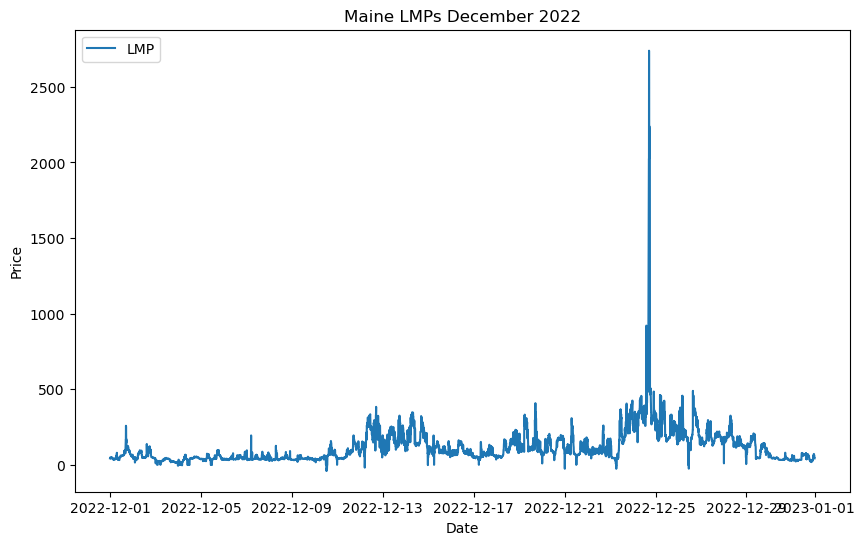

In [97]:
gf.line_single(lmp_maine_df,1)

We can see clearly that during Winter Storm Elliot, especially on December 25th, the LMP increases substantially. Poweroutage.com states that the storm started 12/23 and was recovered until 12/27. Let's take a closer look:

In [82]:
storm_lmp_df = lmp_maine_df[(lmp_maine_df["Time"] >= "2022-12-23")& (lmp_maine_df["Time"] <= "2022-12-28")]

Enter x-axis colname: Time
Enter colname: LMP
Enter title: Maine LMP During Winter Storm Elliot
Enter y-axis label: Price
Enter x-axis label: Date


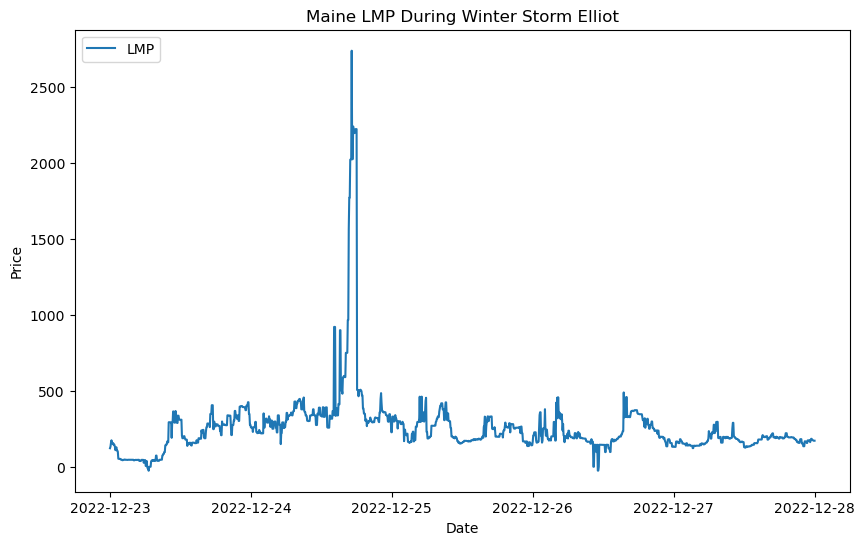

In [83]:
gf.line_single(storm_lmp_df,1)

## Congestion and Loss impact on LMPs in Maine December 2022

First, we'll plot just the congestion and loss:

Enter x-axis colname: Time
Enter colname: Congestion
Enter colname: Loss
Enter title: Congestion and Loss Maine December 2022
Enter y-axis label: Prices
Enter x-axis label: Date


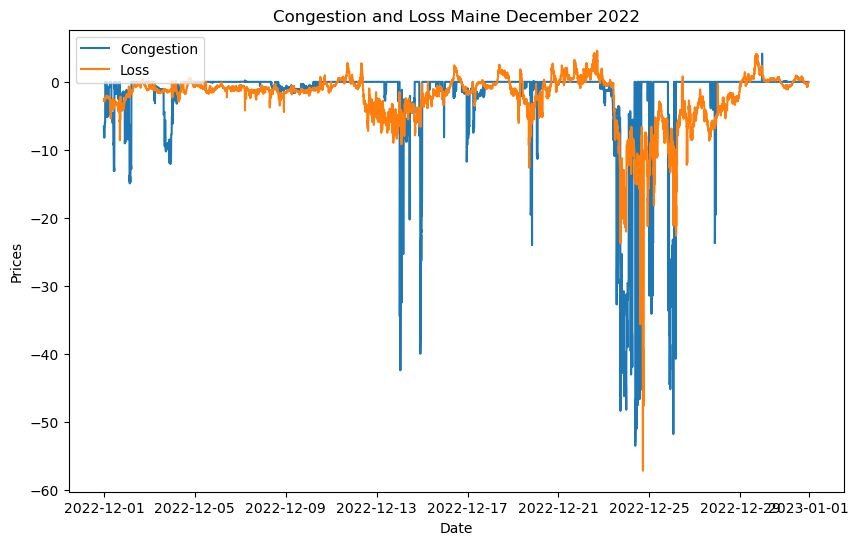

In [96]:
gf.line_single(lmp_maine_df,2)

It's hard to make super meaningful observations but here are two:

1. it appears that congestion is typically more volatile than loss. 
2. Both increase substantially during the winter storm.

Now, congestion and loss during the storm to get a closer look:

Enter x-axis colname: Time
Enter colname: Congestion
Enter colname: Loss
Enter title: Congestion and Loss in Maine during Winter Storm Elliott
Enter y-axis label: Price
Enter x-axis label: Date


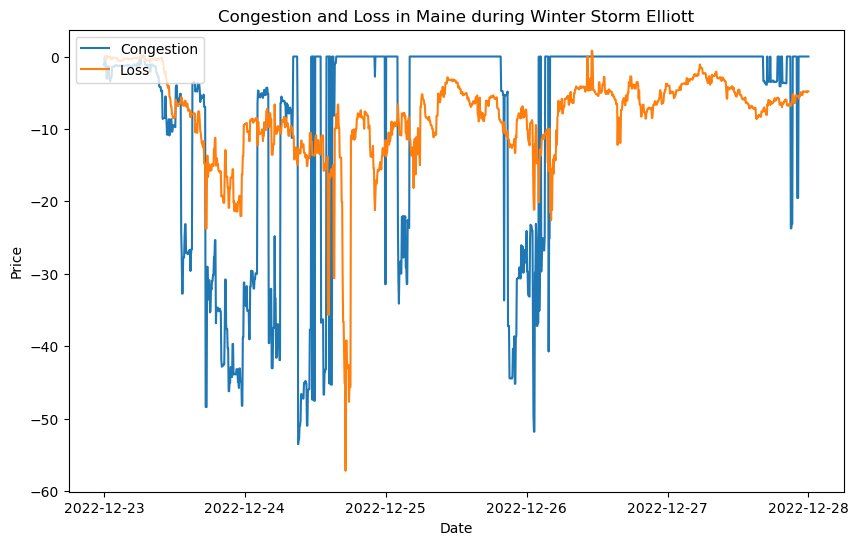

In [98]:
gf.line_single(storm_lmp_df,2)

It would be interesting to combine this with outage data to see comparisons.

In [107]:
lmp_maine_df["Energy - LMP"] = lmp_maine_df["Energy"] - lmp_maine_df["LMP"]

Enter x-axis colname: Time
Enter colname: Energy - LMP
Enter title: Energy & LMP Price Difference Maine December 2022
Enter y-axis label: Price
Enter x-axis label: Date


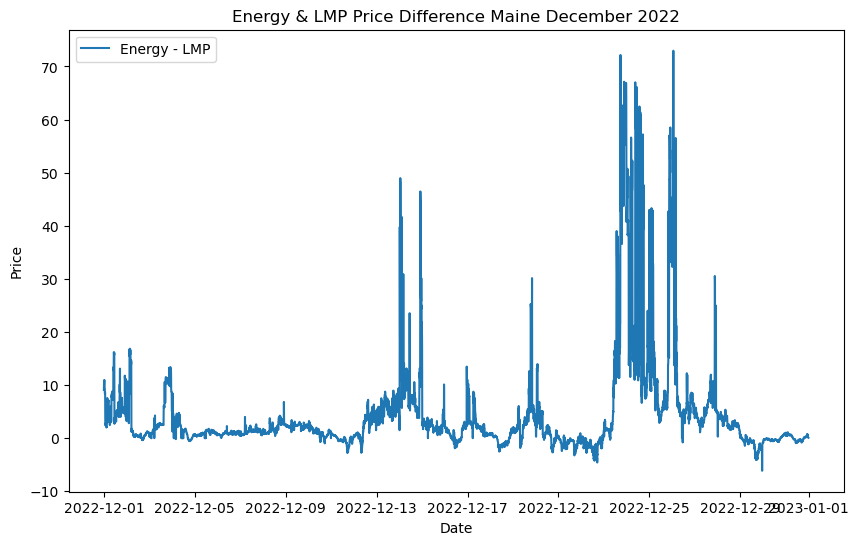

In [111]:
gf.line_single(lmp_maine_df,1)

When there's more congestion and loss, the price of Energy is driven up. Little congestion and loss closes the gap between the energy price and the LMP. It is evident that the cost of power was significantly driven up during the winter storm and congestion and loss became a more sizeable portion of that price during this period.

Enter x-axis colname: Time
Enter colname: LMP
Which axis? (left or right): right
Enter colname: Congestion
Which axis? (left or right): left
Enter colname: Loss
Which axis? (left or right): left
Enter title: LMP, Congestion, and Loss During Winter Storm Elliot in Maine
Enter left y-axis label: Price Elements
Enter x-axis label: Price
Enter right y-axis label: Price


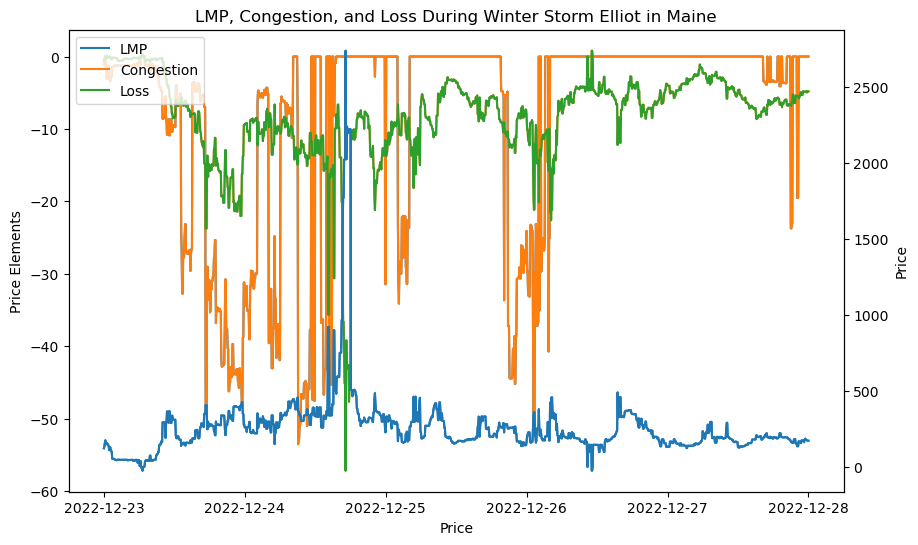

In [117]:
gf.line_dual(storm_lmp_df,3)

## Plotting ISONE Load for December 2022

Enter x-axis colname: Time
Enter colname: Load
Enter title: ISONE Load December 2022
Enter y-axis label: Load
Enter x-axis label: Date


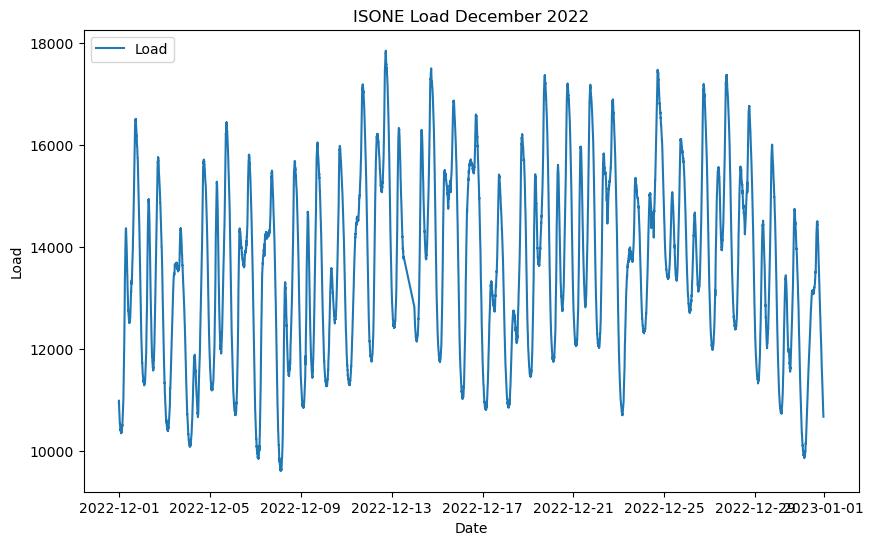

In [85]:
gf.line_single(load_df,1)

Looking just at the storm dates:

In [86]:
storm_load_df = load_df[(load_df["Time"] >= "2022-12-23")& (load_df["Time"] <= "2022-12-28")]

Enter x-axis colname: Time
Enter colname: Load
Enter title: 2022 Winter Storm Elliott ISONE Load
Enter y-axis label: Load
Enter x-axis label: Date


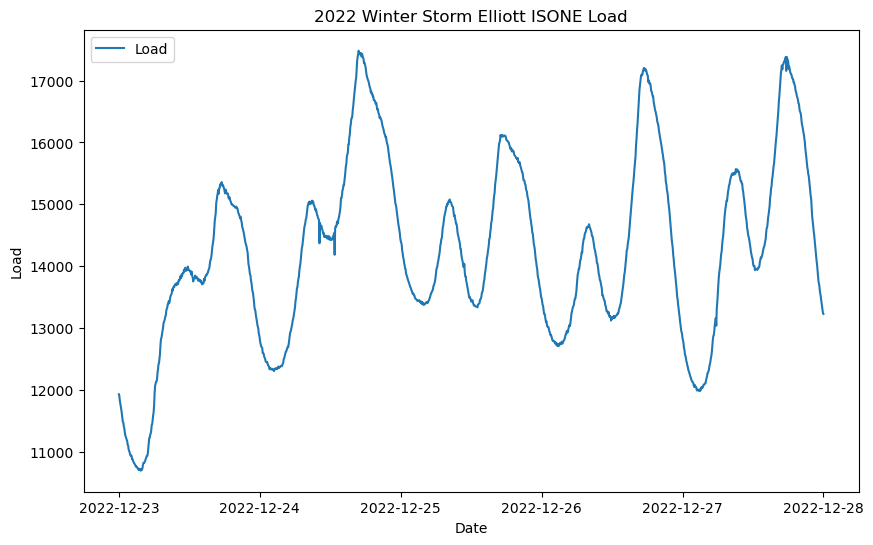

In [88]:
gf.line_single(storm_load_df,1)

Load during the storm doesn't look a whole lot different than load across the whole month. When is peak load on average in December 2022?

In [90]:
hourly_load_df = gf.hourly_data(load_df)

Enter x-axis colname: Time
***Invalid colname***
Enter x-axis colname: Hour
Enter colname: Load
Enter title: ISONE Average Hourly Load December 2022 
Enter y-axis label: Load
Enter x-axis label: Hour


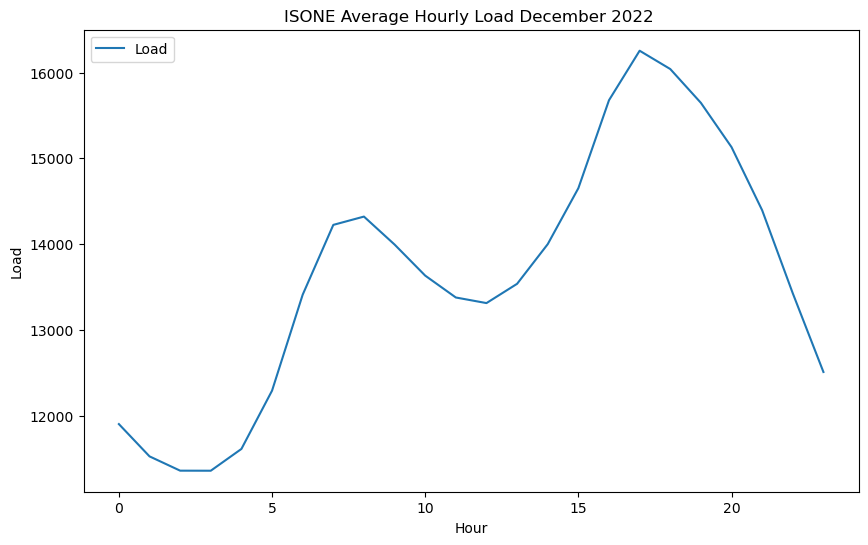

In [92]:
gf.line_single(hourly_load_df,1)

## Plotting Fuel Mix

In [145]:
mix_df.head()

,Time,Coal,Hydro,Landfill Gas,Natural Gas,Nuclear,Oil,Other,Refuse,Solar,Wind,Wood,Hour
0,2022-12-01 00:05:13-05:00,8.0,916.0,31.0,3869.0,3365.0,0.0,0.0,283.0,1.0,991.0,158.0,0
1,2022-12-01 00:11:11-05:00,6.0,916.0,31.0,4023.0,3366.0,0.0,0.0,283.0,1.0,1014.0,159.0,0
2,2022-12-01 00:22:31-05:00,0.0,903.0,31.0,4101.0,3366.0,0.0,0.0,283.0,1.0,1029.0,157.0,0
3,2022-12-01 00:32:43-05:00,1.0,894.0,31.0,4093.0,3365.0,0.0,5.0,277.0,1.0,990.0,157.0,0
4,2022-12-01 00:39:01-05:00,3.0,893.0,31.0,4030.0,3365.0,0.0,1.0,284.0,1.0,991.0,158.0,0


In [146]:
mix_df["total"] = mix_df.sum(axis=1)

/var/folders/fb/lsg_5xw57mz9vhkmk6dvkfkw0000gn/T/ipykernel_94838/530574969.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mix_df["total"] = mix_df.sum(axis=1)


In [147]:
mix_df["Coal%"] = mix_df["Coal"] / mix_df["total"]

In [149]:
cols = mix_df.columns[1:-2]
for c in cols:
    mix_df[c+'%'] = mix_df[c] / mix_df["total"]

In [150]:
cols

Index(['Coal', 'Hydro', 'Landfill Gas', 'Natural Gas', 'Nuclear', 'Oil',
       'Other', 'Refuse', 'Solar', 'Wind', 'Wood'],
      dtype='object')

Enter x-axis colname: Time
Enter colname: Coal%
Enter colname: Hydro%
Enter colname: Landfill Gas%
Enter colname: Natural Gas%
Enter colname: Nuclear%
Enter colname: Oil%
Enter colname: Refuse%
Enter colname: Solar%
Enter colname: Wind%
Enter colname: Wood%
Enter title: Fuel Mix Maine December 2022
Enter y-axis label: Percentage
Enter x-axis label: Date


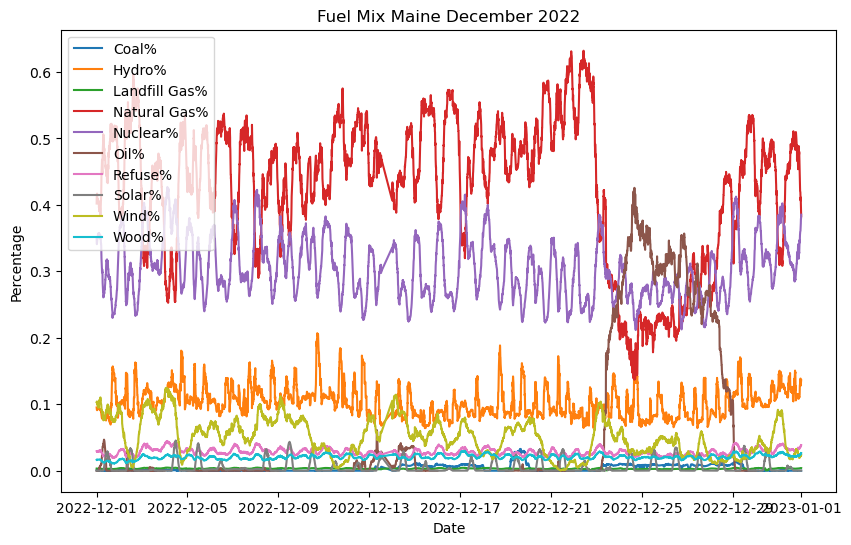

In [153]:
#adjust title: This is the entrie ISO not just Maine

gf.line_single(mix_df,10)

It's clear that during the winter storm, natural gas production failed and demand had to be satisfied with oil. It's winter in New England so there is very low renewable penetration, and high natural gas and nuclear penetration. There is moderate hydro penetration.

## Plotting Hourly Fuel Mix ISONE December 2022

In [163]:
mix_df_hourly = gf.hourly_data_by_day(mix_df)

Enter x-axis colname: Time
Enter colname: Natural Gas%
Enter colname: Nuclear%
Enter colname: Oil%
Enter colname: Wind%
Enter colname: Hydro%
Enter title: Hourly Fuel Mix Maine December 2022
Enter y-axis label: Percentage
Enter x-axis label: Date


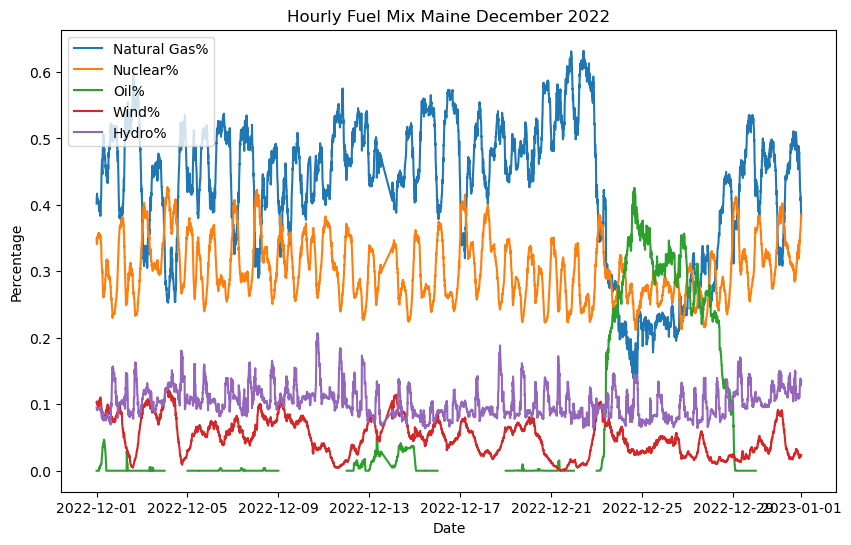

In [165]:
gf.line_single(mix_df,5)

This graph gives a clearer picture of the generation in Maine during December 2022. Wind tops out at around 10% of generation and Natural Gas consistenly provides 50% of the power, except during the winter storm. It takes 2-3 days to ramp back up to regular generation.

## Average Daily Fuel Mix ISONE December 2022

In [167]:
hourly_mix = gf.hourly_data(mix_df)

Enter x-axis colname: Hour
Enter colname: Natural Gas%
Enter colname: Nuclear%
Enter colname: Wind%
Enter colname: Hydro%
Enter title: ISONE Average Daily Fuel Mix by Hour December 2022
Enter y-axis label: Percentage
Enter x-axis label: Time


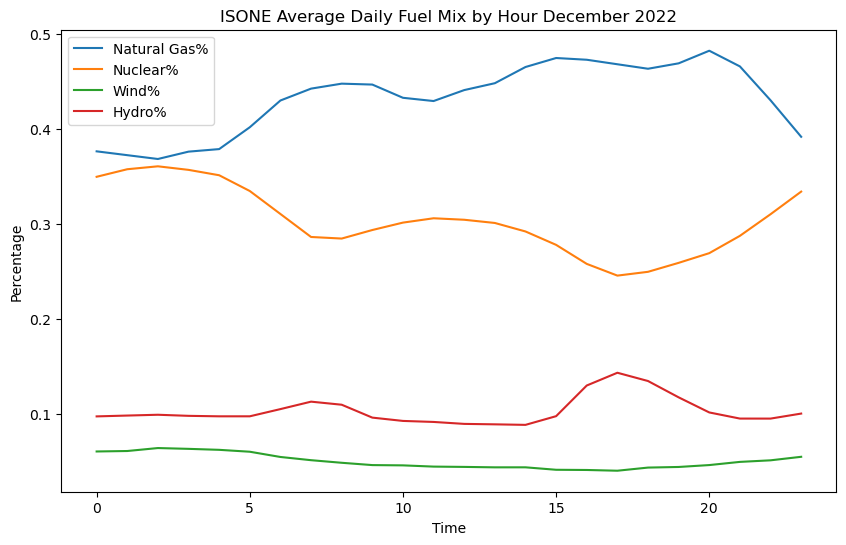

In [169]:
gf.line_single(hourly_mix,4)

Natural gas production increases throughout the day and peaks just after dinnertime. This corresponds with peak load. Generation can be increased quickly on these natural gas to satisfy peak load.

## Average Daily Fuel Mix Stacked Bar Chart by Total Generation

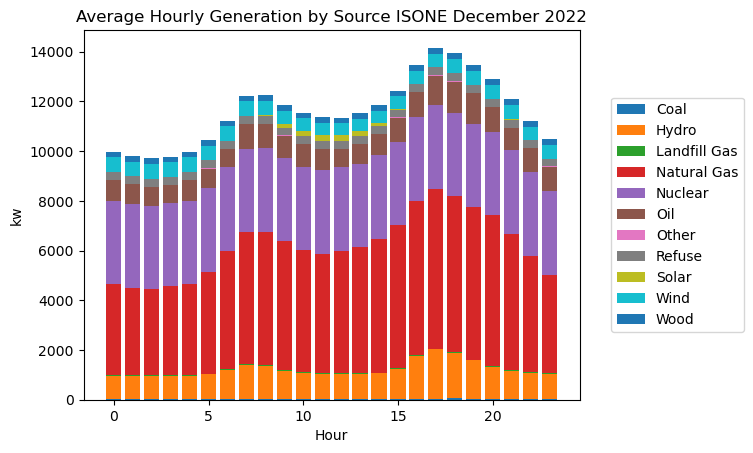

In [212]:
# Create stacked bar chart
fig, ax = plt.subplots()

for col in hourly_mix.columns[:11]:
    ax.bar(hourly_mix.index, hourly_mix[col], 
           label=col, bottom=hourly_mix[hourly_mix.columns[:list(hourly_mix.columns).index(col)]].sum(axis=1))

# Add labels and legend
ax.set_xlabel('Hour')
ax.set_ylabel('kw')
ax.set_title('Average Hourly Generation by Source ISONE December 2022')
plt.legend(bbox_to_anchor=(1.05, .5), loc='center left')

# Show the chart
plt.show()

## Conclusions

**Coding**

1. Getting the data hourly is important when comparing different datasets

**Data**

1. Daily demand peaks around 5 pm
2. The LMP increases at peak demand
3. The LMP skyrocketed during Winter Storm Elliot, peaking at over 2500/kwh on December 24
4. Natural gas consumption not only increases at peak demand, but increases as a percentage of overall generation at peak demand. This means natural gas production is needed to satisfy peak demanda. This is likely because it can be ramped up quickly. 
5. Average natural gas consumption by hour as a percentage of total consumption by hour functions inversely propotionately to that of nuclear.
6. Natural gas production could not withstand the winter storm and was replaced by oil during that time.